## Analysis of Labels Versus Tracker Outputs

Feb 4

In [94]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# Configure analysis

root = 'D:/bme/'
labels_dir = 'labels/coords/'
logs_dir = 'logs/'

In [ ]:
# Load coordinates into pandas

labels_df = pd.DataFrame()

for filename in os.listdir(root + labels_dir):
    if filename.endswith(".txt"): 
        file_path = os.path.join(root + labels_dir, filename)
        
        current_df = pd.read_csv(file_path, skiprows=1, header=None, names=['t', 'x', 'y', 'd'])
        current_df['date'] = filename[6:-4]
        
        labels_df = labels_df.append(current_df, ignore_index=True)
labels_df['t'] = pd.to_numeric(labels_df['t'], errors='coerce')
labels_df['x'] = pd.to_numeric(labels_df['x'], errors='coerce')
labels_df['y'] = pd.to_numeric(labels_df['y'], errors='coerce')
labels_df['d'] = pd.to_numeric(labels_df['d'], errors='coerce')


logs_df = pd.DataFrame()
for filename in os.listdir(root + logs_dir):
    if filename.endswith(".txt"): 
        file_path = os.path.join(root + logs_dir, filename)
        
        current_df = pd.read_csv(file_path, skiprows=1, header=None, names=['t', 'x', 'y', 'd'])
        current_df['date'] = filename[8:-4]
        
        logs_df = logs_df.append(current_df, ignore_index=True)
logs_df['t'] = pd.to_numeric(logs_df['t'], errors='coerce')
logs_df['x'] = pd.to_numeric(logs_df['x'], errors='coerce')
logs_df['y'] = pd.to_numeric(logs_df['y'], errors='coerce')
logs_df['d'] = pd.to_numeric(logs_df['d'], errors='coerce')

In [33]:
# Apply simple preprocessing
logs_pdf = logs_df[logs_df['date'] != '20231027_140520']
labels_pdf = labels_df[labels_df['date'] != '20231027_140520']
print(logs_df.shape)
print(logs_pdf.shape)

(7244, 5)
(7152, 5)


In [76]:
logs_pdf.groupby('date').mean().t_freq

date
20231027_140116    20.488717
20231027_140213    12.597683
20231027_140554     4.353336
20231027_140653     4.430802
20231027_140747    14.852130
20231027_140829    17.032349
20231027_140914     8.732326
20231027_140948     8.551399
20231124_163447    16.770039
20231124_164148    16.824404
20231124_164709    20.556322
20231201_152420    15.605705
Name: t_freq, dtype: float64

In [ ]:
logs_pdf['t_diff'] = logs_pdf.groupby('date')['t'].diff() / 1000
logs_pdf['t_diff'].replace(0, np.nan, inplace=True)
logs_pdf['t_freq'] = 1 / logs_pdf['t_diff']

num = logs_pdf.groupby('date').count().t_freq
means = logs_pdf.groupby('date').mean().t_freq
stds = logs_pdf.groupby('date').std().t_freq

In [93]:
temp = pd.merge(num, means, on='date').reset_index()
df = pd.merge(temp, stds, on='date').reset_index()
change = {
    'date' : 'Trial',
    't_freq_x' : 'frame_count',
    't_freq_y' : 'framerate_Hz_mean',
    't_freq' : 'framerate_Hz_std'
}
df.rename(columns=change, inplace=True)

df

,index,Trial,frame_count,framerate_Hz_mean,framerate_Hz_std
0,0,20231027_140116,366,20.488717,12.413439
1,1,20231027_140213,186,12.597683,11.823399
2,2,20231027_140554,158,4.353336,0.555944
3,3,20231027_140653,40,4.430802,0.543818
4,4,20231027_140747,88,14.852130,12.500275
5,5,20231027_140829,74,17.032349,12.713160
6,6,20231027_140914,58,8.732326,9.411275
7,7,20231027_140948,73,8.551399,9.604240
8,8,20231124_163447,1786,16.770039,12.362808
9,9,20231124_164148,1873,16.824404,12.525101


In [ ]:
category_data = {}
for category in df['date'].unique():
    category_data[category] = logs_pdf[logs_pdf['date'] == category]['t_freq']

# Plot stacked histograms on the same axes
plt.hist(category_data.values(), bins=10, alpha=0.7, label=category_data.keys(), edgecolor='black', stacked=True)


array([[<AxesSubplot: title={'center': '20231027_140116'}>,
        <AxesSubplot: title={'center': '20231027_140213'}>,
        <AxesSubplot: title={'center': '20231027_140554'}>],
       [<AxesSubplot: title={'center': '20231027_140653'}>,
        <AxesSubplot: title={'center': '20231027_140747'}>,
        <AxesSubplot: title={'center': '20231027_140829'}>],
       [<AxesSubplot: title={'center': '20231027_140914'}>,
        <AxesSubplot: title={'center': '20231027_140948'}>,
        <AxesSubplot: title={'center': '20231124_163447'}>],
       [<AxesSubplot: title={'center': '20231124_164148'}>,
        <AxesSubplot: title={'center': '20231124_164709'}>,
        <AxesSubplot: title={'center': '20231201_152420'}>]], dtype=object)

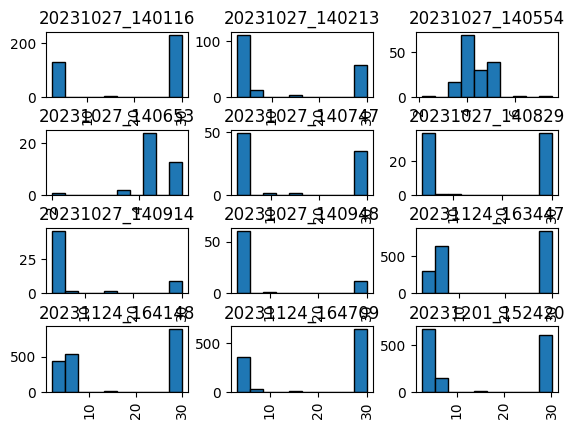

In [96]:
logs_pdf.hist(column='t_freq', by='date', stacked=True, bins=10, edgecolor='black')

In [72]:
logs_pdf.groupby('date').mean().reset_index()[['date', 't_freq_mean', 't_freq_std']]

,date,t_freq_mean,t_freq_std
0,20231027_140116,NaN,NaN
1,20231027_140213,NaN,NaN
2,20231027_140554,NaN,NaN
3,20231027_140653,NaN,NaN
4,20231027_140747,NaN,NaN
5,20231027_140829,NaN,NaN
6,20231027_140914,NaN,NaN
7,20231027_140948,NaN,NaN
8,20231124_163447,NaN,NaN
9,20231124_164148,NaN,NaN


In [40]:
# Get frequencies
logs_pdf['frequency_hz'] = 1 / (logs_pdf.groupby('date')['t'].diff().mean())

np.unique(logs_pdf['date'] )

C:\Users\finno\AppData\Local\Temp\ipykernel_33704\2275564537.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logs_pdf['frequency_hz'] = 1 / (logs_pdf.groupby('date')['t'].diff().mean())


array(['20231027_140116', '20231027_140213', '20231027_140554',
       '20231027_140653', '20231027_140747', '20231027_140829',
       '20231027_140914', '20231027_140948', '20231124_163447',
       '20231124_164148', '20231124_164709', '20231201_152420'],
      dtype=object)